# Segmentación de Cuerpos de Agua


In [7]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, ReLU, MaxPool2D, AvgPool2D, Input, LeakyReLU, concatenate,Conv2DTranspose, UpSampling2D
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras.layers.normalization import BatchNormalization
import math
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import nibabel as nib
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg

from tensorflow.keras.models import Model
from keras.layers import add

### Importar dataset desde repositorio GitHub

In [83]:
!git clone https://github.com/leonardtd/TAC-Segmentacion-de-cuerpos-de-agua

Cloning into 'TAC-Segmentacion-de-cuerpos-de-agua'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 26 (delta 6), reused 11 (delta 1), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [84]:
%cd TAC-Segmentacion-de-cuerpos-de-agua

/content/TAC-Segmentacion-de-cuerpos-de-agua/TAC-Segmentacion-de-cuerpos-de-agua


In [ ]:
!unzip 'Resized Images.zip'

In [ ]:
!unzip 'Resized Masks.zip'

In [6]:
%ls

'Mar Lima Callao.zip'  'Resized Images'/     'Resized Masks'/
 README.md             'Resized Images.zip'  'Resized Masks.zip'


#### Lectura de Imágenes

In [1]:
size = 128

In [8]:
#Función de lectura de datos para imágenes y máscaras
def read_process_data(path, isMask = False):
  if isMask:
    data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    data[data<=127] = 0
    data[data>127] = 1
  else:
    data = cv2.imread(path, cv2.IMREAD_COLOR)
    data = cv2.normalize(data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
  return data

In [9]:
#lectura de data
images_paths = [("./Resized Images/" + x) for x in os.listdir("Resized Images")]
images_paths.sort()
#Separación de paths de entrenamiento y prueba
train_images_paths = images_paths[0:-round(0.1*len(images_paths))]
test_images_paths = images_paths[len(train_images_paths):len(images_paths)]

masks_paths = [("./Resized Masks/" + x) for x in os.listdir("Resized Masks")]
masks_paths.sort()

#Separación de paths de entrenamiento y prueba
train_masks_paths = masks_paths[0:-round(0.1*len(masks_paths))]
test_masks_paths = masks_paths[len(train_masks_paths):len(masks_paths)]

print("Resized Images scan with length of: {}".format(len(images_paths)))
print("Resized Masks scan with length of: {}".format(len(masks_paths)))

Resized Images scan with length of: 2516
Resized Masks scan with length of: 2516


In [10]:
#lectura de las imagenes de entrenamiento
%%time
images = np.array([read_process_data(path) for path in train_images_paths])

CPU times: user 1.07 s, sys: 3.65 s, total: 4.73 s
Wall time: 4.73 s


In [11]:
#lectura de las imagenes
%%time
masks = np.array([read_process_data(path, True) for path in train_masks_paths])

CPU times: user 413 ms, sys: 49.8 ms, total: 463 ms
Wall time: 467 ms


#### Mostramos algunas imágenes del dataset

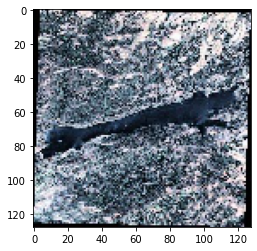

In [12]:
sample_image = mpimg.imread(train_images_paths[-2])
plt.imshow(sample_image)
plt.show()

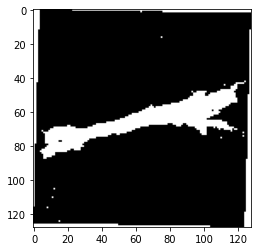

In [13]:
plt.imshow(masks[-2].reshape(128,128), cmap='gray')

In [14]:
images = images.reshape((-1, size, size, 3))
masks = masks.reshape((-1, size, size, 1))

In [15]:
#Comprobamos las dimensiones del dataset
print("images shape: {} masks shape: {}".format(images.shape,masks.shape))

images shape: (2264, 128, 128, 3) masks shape: (2264, 128, 128, 1)


#### Data Augmentation

In [16]:
#Aumentaremos el corpus de datos en 20% tanto para las imágenes como máscaras
INCREMENT_PERC = 0.2
sample_images = images[0:round(INCREMENT_PERC * len(images))]
sample_masks = masks[0:round(INCREMENT_PERC * len(masks))]

In [17]:
#Horizontal flip
da_images = np.array([cv2.flip(img, 1) for img in sample_images])
da_masks = np.array([cv2.flip(mask,1) for mask in sample_masks])

In [18]:
#Liberamos memoria
del sample_images, sample_masks

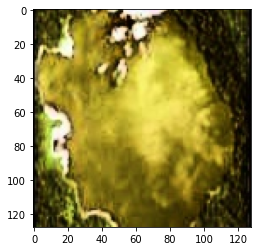

In [19]:
plt.imshow(images[8].reshape(128,128,3))

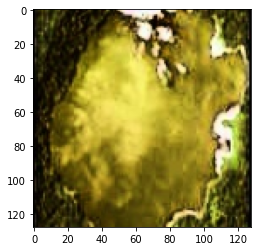

In [20]:
plt.imshow(da_images[8].reshape(128,128,3))

In [21]:
da_images - da_images.reshape(-1,size,size,3)
da_masks = da_masks.reshape(-1,size,size,1)

In [22]:
images = np.concatenate((images,da_images))
masks = np.concatenate((masks,da_masks))
del da_images, da_masks

#### Separacion en tensores de entrenamiento y validación

In [32]:
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.20, random_state=42)

In [33]:
y_train.shape

(2173, 128, 128, 1)

In [34]:
bs = 128
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_train = dataset_train.shuffle(buffer_size=1280).batch(bs).prefetch(100)
dataset_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
dataset_val = dataset_val.batch(bs).prefetch(100)

### Definición del modelo


---



In [2]:
def encoder_module(in_layer, n_filters):
  x = in_layer
  saved_layers = []
  #array ---> [64,128,256,512]
  for filters in [n_filters,n_filters<<1,n_filters<<2,n_filters<<3]:
    x = Conv2D(filters, kernel_size=3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = Conv2D(filters, kernel_size=3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
    #push a la pila de capas guardadas
    saved_layers.insert(0,x)
    x = MaxPool2D(2, padding="same")(x)
  
  x = Conv2D(n_filters<<4, kernel_size=3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
  #saved layers es [(512,), (256,), (128,), (64,)]
  return x, saved_layers

In [3]:
def decoder_module(last_layer,n_filters,saved_layers):
  x = last_layer
  #array ---> [512,256,128,64]
  for (filters,add_layer) in zip([n_filters>>1,n_filters>>2,n_filters>>3,n_filters>>4], saved_layers):
    #UpSampling
    x = UpSampling2D(2)(x)
    #DeConvolutions
    x = Conv2DTranspose(filters, kernel_size=3, padding="same")(x)
    x = Conv2DTranspose(filters, kernel_size=3, padding="same")(x)
    #Suma de Capas
    x = add([x,add_layer])

  return x

In [4]:
num_classes = 1 #Solo se tienen las clases 1 y 0 que indica si es o no es un cuerpo de agua
def create_unet():
  #El numero de filtros es un hiperparametro
  min_filters = 64
  max_filters = 1024

  in_layer = Input(shape=(size,size,3))
  #Encoder
  last_layer, saved_layers = encoder_module(in_layer,min_filters)
  #Decoder
  decoded_layer = decoder_module(last_layer,max_filters,saved_layers)
  #Outpus
  outputs = Conv2D(num_classes, 3, activation="sigmoid", padding="same")(decoded_layer)
  model = Model(inputs=in_layer, outputs=outputs)
  return model

In [8]:
#Modelo
model = create_unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

#### Custom Metrics: F1 score

In [6]:
#Métrica F1 score: adaptada de stack overflow
#https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Entrenamiento



In [40]:
#run with checkpoint
checkpoint_path = "my_model/model"
monitor = "val_accuracy"
mode = "max"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor=monitor, verbose=1, save_best_only=True, save_weights_only=True, mode=mode)

In [41]:
#Probar con diferentes loss functions
model.compile(optimizer='adam',loss='binary_crossentropy', metrics = ['accuracy',f1])

In [ ]:
model.summary()

In [43]:
log = model.fit(dataset_train, batch_size=bs,epochs=50, validation_data=dataset_val,callbacks=[model_checkpoint])

Epoch 1/50
17/17 [==============================] - 112s 3s/step - loss: 121.9665 - accuracy: 0.5392 - f1: 0.2506 - val_loss: 5.6265 - val_accuracy: 0.6827 - val_f1: 0.0088

Epoch 00001: val_accuracy improved from -inf to 0.68268, saving model to my_model/model
Epoch 2/50
17/17 [==============================] - 23s 1s/step - loss: 1.5086 - accuracy: 0.5690 - f1: 0.1733 - val_loss: 0.6783 - val_accuracy: 0.5760 - val_f1: 0.2739

Epoch 00002: val_accuracy did not improve from 0.68268
Epoch 3/50
17/17 [==============================] - 24s 1s/step - loss: 0.6184 - accuracy: 0.6702 - f1: 0.1310 - val_loss: 0.5513 - val_accuracy: 0.7422 - val_f1: 0.6141

Epoch 00003: val_accuracy improved from 0.68268 to 0.74217, saving model to my_model/model
Epoch 4/50
17/17 [==============================] - 24s 1s/step - loss: 0.5511 - accuracy: 0.7345 - f1: 0.4695 - val_loss: 0.5143 - val_accuracy: 0.7414 - val_f1: 0.3500

Epoch 00004: val_accuracy did not improve from 0.74217
Epoch 5/50
17/17 [======

In [44]:
#Cargar el modelo a partir del checkpoint
model.load_weights(checkpoint_path)

####Guardamos el modelo en drive

 ---

In [ ]:
from google.colab import drive
drive.mount("/drive")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
%cd "/drive/MyDrive/TAC/TA Final/model"

/drive/MyDrive/TAC/TA Final/model


In [ ]:
%ls

 prueba/                               'val_acc: 0.87785'/
 TAC-Segmentacion-de-cuerpos-de-agua/  'val_acc: 0.89254'/


In [ ]:
#model.save('val_acc: 0.89254')

INFO:tensorflow:Assets written to: val_acc: 0.89254/assets


In [ ]:
#Cargar el modelo de drive
model.load_weights('val_acc: 0.89254')

#### Visualizando el entrenamiento

In [45]:
def plot_loss(log):
  loss = log.history['loss']
  val_loss = log.history['val_loss']
  
  fig = plt.figure(figsize=(10, 5))

  plt.plot(loss, label='train')
  plt.plot(val_loss, label='validation')
  
  plt.xlabel('epoch'); plt.ylabel('loss')
  
  plt.legend()

  plt.show()

def plot_accuracy(log):
  accuracy = log.history['accuracy']
  val_accuracy = log.history['val_accuracy']
  
  fig = plt.figure(figsize=(10, 5))

  plt.plot(accuracy, label='train')
  plt.plot(val_accuracy, label='validation')
  
  plt.xlabel('epoch'); plt.ylabel('accuracy')
  
  plt.legend()

  plt.show()

def plot_f1_score(log):
  f1 = log.history['f1']
  val_f1 = log.history['val_f1']
  
  fig = plt.figure(figsize=(10, 5))

  plt.plot(f1, label='train')
  plt.plot(val_f1, label='validation')
  
  plt.xlabel('epoch'); plt.ylabel('f1 score')
  
  plt.legend()

  plt.show()

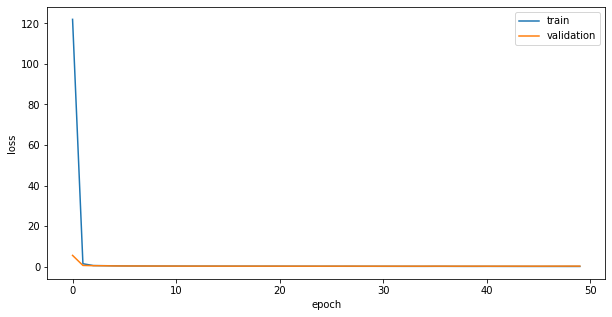

In [46]:
plot_loss(log)

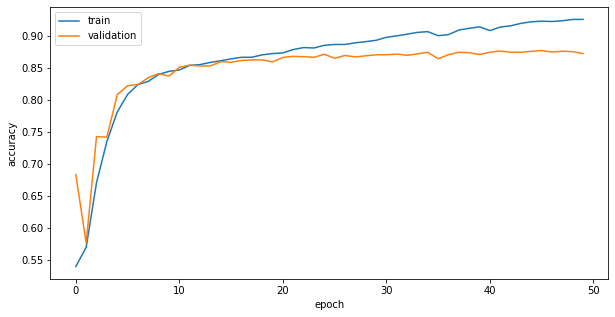

In [47]:
plot_accuracy(log)

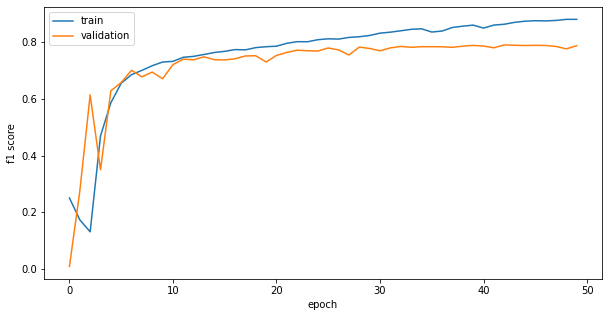

In [48]:
plot_f1_score(log)

In [63]:
import colorsys
from PIL import ImageOps
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import random
from tensorflow.keras.preprocessing.image import array_to_img

def random_colors(N, bright=True):
  brightness = 1.0 if bright else 0.7
  hsv = [(i / N, 1, brightness) for i in range(N)]
  colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
  random.shuffle(colors)
  return colors

def apply_mask(image, mask, alpha=0.5):
  colors = random_colors(2)

  for c in range(3):
    image[:, :, c] = np.where(mask != 0,
                              np.where(mask != 1,
                                       alpha * colors[1][c] * 255 + image[:, :, c] * (1 - alpha),
                                       alpha * colors[1][c] * 255 + image[:, :, c] * (1 - alpha)),
                              image[:, :, c])
  return image

def display_prediction(index, img_size, val_input_img_paths, val_target_img_paths, predictions):
  display(Image(filename=val_input_img_paths[index]))
  if val_target_img_paths:
    img = ImageOps.autocontrast(load_img(val_target_img_paths[index]))
    display(Image(filename=val_target_img_paths[index]))
  
  #predictions[index].shape -------> (128, 128, 3)
  mask = np.asarray(predictions[index]).reshape(128,128) # (128, 128)\

  image_loaded = load_img(val_input_img_paths[index])
  image_resized = np.array(image_loaded)
  image_resized_with_mask = apply_mask(image_resized, mask)

  mask = np.expand_dims(mask, axis=-1) # (128, 128, 1)
  
  img = ImageOps.autocontrast(array_to_img(mask))
  
  display(img)

  display(array_to_img(image_resized_with_mask))

#### Cargamos las imágenes a predecir

In [50]:
%cd TAC-Segmentacion-de-cuerpos-de-agua

[Errno 2] No such file or directory: 'TAC-Segmentacion-de-cuerpos-de-agua'
/content/TAC-Segmentacion-de-cuerpos-de-agua


In [51]:
#lectura de las imagenes de entrenamiento
%%time
images_to_predict = np.array([read_process_data(path) for path in test_images_paths])

CPU times: user 143 ms, sys: 29.8 ms, total: 173 ms
Wall time: 214 ms


In [52]:
#lectura de las imagenes
%%time
masks_to_predict = np.array([read_process_data(path, True) for path in test_masks_paths])

CPU times: user 49 ms, sys: 10.2 ms, total: 59.3 ms
Wall time: 113 ms


In [53]:
predictions = model.predict(images_to_predict)

In [54]:
#Muestra de predicción
index = 181

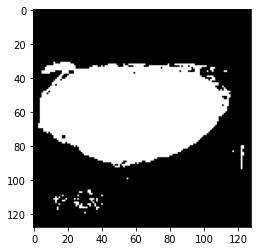

In [55]:
plt.imshow(masks_to_predict[index].reshape(128,128),cmap='gray')

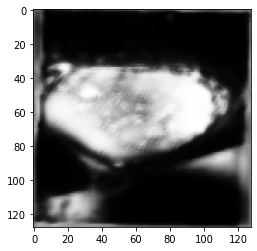

In [56]:
mask = np.asarray(predictions[index])
plt.imshow(mask.reshape(128,128),cmap='gray')

In [57]:
def set_threshold(predictions):
  p = []
  for image in predictions:
    image[image<=0.35] = 0
    image[image>0.35] = 1
    p.append(image)
  return p

In [58]:
#Seteamos un umbral para las prediciones de las máscaras
predictions_w_threshold = set_threshold(predictions)

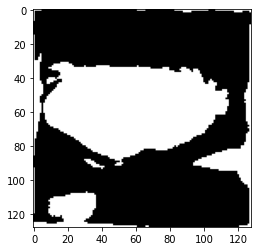

In [59]:
#Muestra de la predicción con el umbral
plt.imshow(predictions_w_threshold[index].reshape(128,128),cmap='gray')

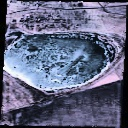

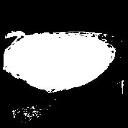

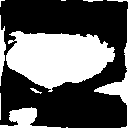

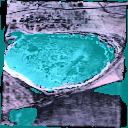

In [64]:
display_prediction(index, size, test_images_paths, test_masks_paths, predictions)

### F1 score

In [69]:
predictions = model.predict(images_to_predict)

In [70]:
THRESHOLD = 0.35

def apply_threshold(prediction):
  p = np.array([])
  p = np.concatenate((p,prediction.reshape(-1,)))
  p[p<=THRESHOLD] = 0
  p[p>THRESHOLD] = 1
  return p

In [71]:
prediction_sample = predictions[index+1]
mask_sample = masks_to_predict[index+1]

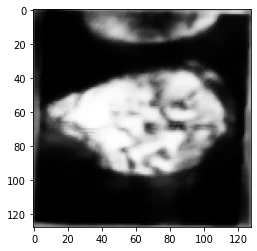

In [72]:
plt.imshow(prediction_sample.reshape(size,size),cmap='gray')

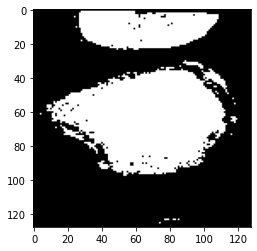

In [73]:
plt.imshow(mask_sample.reshape(size,size),cmap='gray')

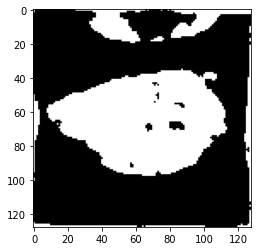

In [74]:
#Primero se aplica el threshold
prediction_test = apply_threshold(prediction_sample)
plt.imshow(prediction_test.reshape(size,size),cmap='gray')

In [75]:
def recall(mask,prediction):
  tp = 0
  fn = 0

  for (mask_p,prediction_p) in zip(mask.reshape(-1,),prediction.reshape(-1,)):
    #true positive
    if prediction_p and  mask_p:
      tp = tp + 1
    #false negative
    elif  prediction_p == 0 and mask_p:
      fn = fn+1
  
  return tp/(tp+fn)

def precision(mask,prediction):
  tp = 0
  fp = 0

  for (mask_p,prediction_p) in zip(mask.reshape(-1,),prediction.reshape(-1,)):
    #true positive
    if prediction_p and  mask_p:
      tp = tp + 1
    #false positive
    elif  prediction_p and ~mask_p:
      fp = fp+1
  
  return tp/(tp+fp)

def f1_score(recall,precision):
  return 2*recall*precision/(recall+precision)

rec = recall(mask_sample,prediction_test)
prec = precision(mask_sample,prediction_test)
f1 = f1_score(rec, prec)

print("Recall: {} Precision: {} F1 Score: {}".format(rec,prec,f1))

Recall: 0.8039083557951483 Precision: 0.8477527091845799 F1 Score: 0.8252485948984004


**Algunas predicciones**

Recall: 0.8039083557951483 
Precision: 0.8477527091845799 
F1 Score: 0.8252485948984004


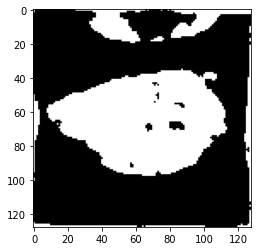

In [76]:
#Predecir imagen
prediction_sample = predictions[index+1]
mask_sample = masks_to_predict[index+1]


prediction_test = apply_threshold(prediction_sample)
plt.imshow(prediction_test.reshape(size,size),cmap='gray')

rec = recall(mask_sample,prediction_test)
prec = precision(mask_sample,prediction_test)
f1 = f1_score(rec, prec)

print("Recall: {} \nPrecision: {} \nF1 Score: {}".format(rec,prec,f1))

Recall: 0.8290727902946274 
Precision: 0.9379901960784314 
F1 Score: 0.8801747930082796


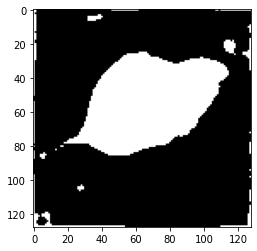

In [78]:
#Predecir imagen
prediction_sample = predictions[index+64]
mask_sample = masks_to_predict[index+64]


prediction_test = apply_threshold(prediction_sample)
plt.imshow(prediction_test.reshape(size,size),cmap='gray')

rec = recall(mask_sample,prediction_test)
prec = precision(mask_sample,prediction_test)
f1 = f1_score(rec, prec)

print("Recall: {} \nPrecision: {} \nF1 Score: {}".format(rec,prec,f1))

Recall: 0.9873402312842362 
Precision: 0.9565986555018281 
F1 Score: 0.9717263687552414


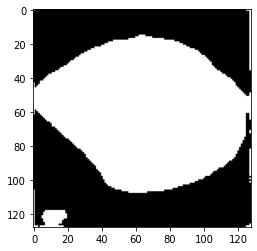

In [79]:
#Predecir imagen
prediction_sample = predictions[175]
mask_sample = masks_to_predict[175]


prediction_test = apply_threshold(prediction_sample)
plt.imshow(prediction_test.reshape(size,size),cmap='gray')

rec = recall(mask_sample,prediction_test)
prec = precision(mask_sample,prediction_test)
f1 = f1_score(rec, prec)

print("Recall: {} \nPrecision: {} \nF1 Score: {}".format(rec,prec,f1))

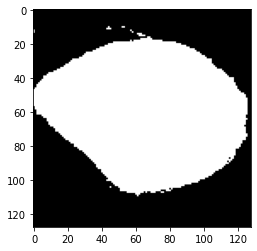

In [80]:
plt.imshow(mask_sample.reshape(size,size),cmap='gray')

## Predicción Final con imagen de Lima - Callao

In [81]:
%cd TAC-Segmentacion-de-cuerpos-de-agua

[Errno 2] No such file or directory: 'TAC-Segmentacion-de-cuerpos-de-agua'
/content/TAC-Segmentacion-de-cuerpos-de-agua


In [85]:
!unzip 'Mar Lima Callao.zip'

Archive:  Mar Lima Callao.zip
  inflating: Mar Lima Callao/lima_callao.jpg  


In [86]:
%cd Mar Lima Callao

/content/TAC-Segmentacion-de-cuerpos-de-agua/TAC-Segmentacion-de-cuerpos-de-agua/Mar Lima Callao


Imagen de Mar de Lima Callao

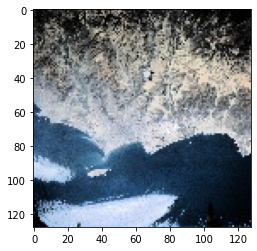

In [87]:
sample_image = mpimg.imread('./lima_callao.jpg')
plt.imshow(sample_image)
plt.show()

In [88]:
#Normalizamos la imagen antes de realizar la predicción
img = cv2.imread('./lima_callao.jpg', cv2.IMREAD_COLOR)
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)

In [89]:
predicted_img = model.predict(img.reshape(1,size,size,3))

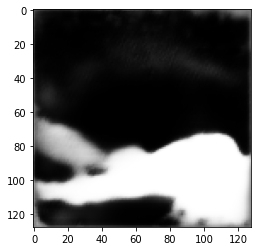

In [90]:
plt.imshow(predicted_img.reshape(size,size),cmap='gray')

In [ ]:
%ls

lima_callao.jpg


In [91]:
def show_prediction( img_size, val_input_img_paths, prediction):
  display(Image(filename=val_input_img_paths))
  
  #predictions[index].shape -------> (128, 128, 3)
  mask = np.asarray(prediction).reshape(128,128) # (128, 128)\

  image_loaded = load_img(val_input_img_paths)
  image_resized = np.array(image_loaded)
  image_resized_with_mask = apply_mask(image_resized, mask)

  mask = np.expand_dims(mask, axis=-1) # (128, 128, 1)
  
  img = ImageOps.autocontrast(array_to_img(mask))
  
  display(img)

  display(array_to_img(image_resized_with_mask))

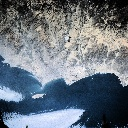

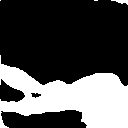

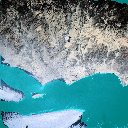

In [92]:
show_prediction(size, './lima_callao.jpg', apply_threshold(predicted_img))